##Step 1: Install Dependencies


In [1]:
!pip install pyspark textblob newsapi-python

##Step 2: Imports and Spark Session Setup


In [2]:
import os
import requests
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob
from typing import List, Dict
from getpass import getpass

spark = (
    SparkSession.builder
    .appName("ColabNewsSentimentAnalysis")
    .master("local[*]")
    .getOrCreate()
)

##Step 3: News Fetching Function


In [3]:
def fetch_latest_news(api_key: str, query: str = 'technology') -> list[dict]:
    url = f"https://newsdata.io/api/1/news?apikey={api_key}&q={query}&language=en"

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        articles = data.get('results', [])

        formatted_articles = [
            {
                "title": article.get("title"),
                "description": article.get("description"),
                "url": article.get("link"),
                "source": article.get("source_id")
            }
            for article in articles if article.get("title")
        ]
        return formatted_articles

    except requests.exceptions.RequestException as e:
        print(f"Error fetching news: {e}")
        return []

NEWSDATA_API_KEY = getpass('Enter your newsdata.io API key: ')

Enter your newsdata.io API key: ··········


##Step 4: Sentiment Analysis

In [4]:
def classify_sentiment(text: str) -> str:
    if not text:
        return 'Neutral'
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def analyze_news_sentiment(articles: List[Dict]) -> List[Dict]:
    if not articles:
        return []

    news_df = spark.createDataFrame(articles)

    sentiment_udf = udf(classify_sentiment, StringType())

    classified_df = news_df.withColumn("sentiment", sentiment_udf(news_df["title"]))

    results = [row.asDict() for row in classified_df.collect()]
    return results

In [20]:
print("Fetching latest news from newsdata.io...")
raw_articles = fetch_latest_news(NEWSDATA_API_KEY, query='India')

if raw_articles:
    print(f"Fetched {len(raw_articles)} articles. Analyzing sentiment with PySpark...")
    classified_articles = analyze_news_sentiment(raw_articles)
    print("Analysis complete!")

    for article in classified_articles[:5]:
        print(f"\nTitle: {article['title']}")
        print(f"Sentiment: {article['sentiment']}")
else:
    print("Could not fetch any articles.")

Fetching latest news from newsdata.io...
Fetched 10 articles. Analyzing sentiment with PySpark...
Analysis complete!

Title: The European Troika’s Miscalculation
Sentiment: Neutral

Title: Ekta Kapoor Calls Censor Board 'Much Needed Trouble', Slams Entourage For 'Killing Movies'
Sentiment: Neutral

Title: OnePlus 15 Release Date, Price, Design, Camera, Specifications And More, Everything You Need To Know
Sentiment: Positive

Title: ISSF Junior World Cup: Anushka Thokur wins gold; Adriyan bags silver
Sentiment: Positive

Title: Watch: India trolls Pakistan’s Abrar Ahmed in epic post-win prank — the internet can’t stop laughing!
Sentiment: Positive


##Display Articles by Sentiment

In [21]:
from ipywidgets import Dropdown, Output, VBox
from IPython.display import display

sentiment_counts = {}
for article in classified_articles:
    sentiment = article['sentiment']
    sentiment_counts[sentiment] = sentiment_counts.get(sentiment, 0) + 1

sentiment_dropdown = Dropdown(
    options=list(sentiment_counts.keys()),
    description='Sentiment:',
)

output_widget = Output()

def display_articles_by_sentiment(sentiment):
    with output_widget:
        output_widget.clear_output()
        print(f"Articles with {sentiment} sentiment:")
        count = 0
        for article in classified_articles:
            if article['sentiment'] == sentiment and count < 5:
                print(f"- {article['title']}")
                count += 1
        if count == 0:
            print("No articles found for this sentiment.")

sentiment_dropdown.observe(lambda change: display_articles_by_sentiment(change['new']), names='value')

display(VBox([sentiment_dropdown, output_widget]))

display_articles_by_sentiment(sentiment_dropdown.value)

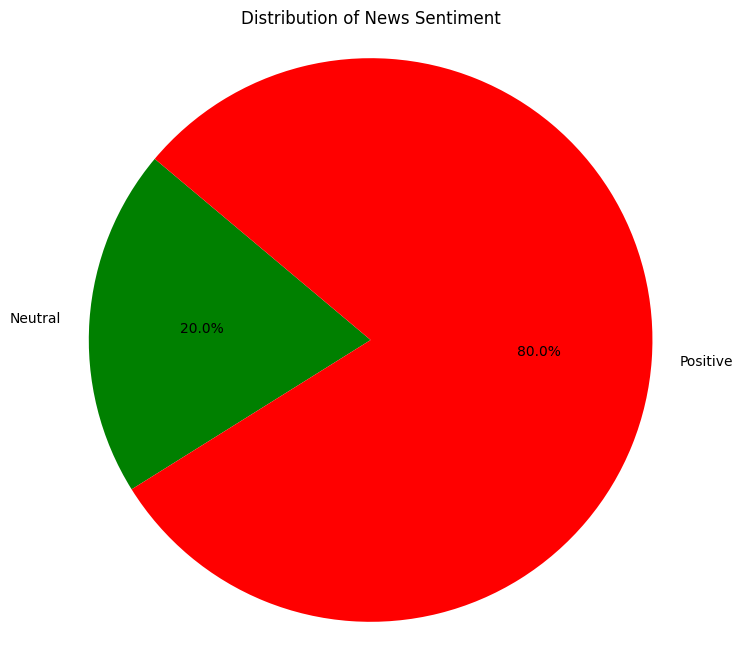

In [22]:
import matplotlib.pyplot as plt

labels = sentiment_counts.keys()
sizes = sentiment_counts.values()
colors = ['green', 'red', 'gray']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of News Sentiment')
plt.axis('equal')
plt.show()